# Vaccine Distribution Program
## DS 2500 Project
### Sanjana Bhagavatula, John Drohan, Ben Nguyen, Nico Gaspar

In [1]:
# Import Functions
%run Functions.ipynb

## Data clean up and analysis

#### Age

In [2]:
# Read csv
age_df = pd.read_csv("Provisional_COVID-19_Death_Counts_by_Sex__Age__and_State.csv")

# Drop redundant rows to look at only ages
age_df = age_df[ (age_df["Group"] == "By Total") & (age_df["State"] == "United States") & (age_df["Sex"] == "All Sexes") ]

# Drop columns to look at only ages and deaths
age_df = age_df[["Age Group", "COVID-19 Deaths"]]

# Drop additional groups to get continuous groups without overlap
additional = [0, 2, 6, 8, 10, 12]
age_df = age_df.drop(additional)

# Add score and threshold age to df
tot = sum(age_df["COVID-19 Deaths"].tolist())
age_df['Score'] = (age_df['COVID-19 Deaths']/tot) * 100
brackets = [0, 1, 5, 15, 25, 35, 45, 55, 65, 75, 85]
age_df['Threshold'] = brackets

# Min max scaler for score
age_df['Score'] = scale_values(age_df['Score'], scaler=MinMaxScaler)

In [3]:
# Read percent of population excel spreadsheet
pop_age_df = pd.read_excel('statistic_id241488_population-of-the-united-states-by-sex-and-age-2019.xlsx', sheet_name = 'Data')
pop_age_df = pop_age_df.drop(columns = ['Unnamed: 0'])
pop_age_df = pop_age_df.drop([0,1,2,3])
pop_age_df.columns = ['Age range', 'Male', 'Female']

pop_age_df['Total'] = pop_age_df['Male'] + pop_age_df['Female']

pop_tot = sum(pop_age_df['Total'].tolist())

pop_age_lst = pop_age_df['Total'].tolist()

# Creating list of portions of population that each age group falls under
pop_est = [(pop_age_lst[0]/5)/pop_tot, # under 1
           (pop_age_lst[0]*4)/5/pop_tot, # 1-4
          (pop_age_lst[1]+pop_age_lst[2])/pop_tot, # 5-14
          (pop_age_lst[3]+pop_age_lst[4])/pop_tot, #15-24
          (pop_age_lst[5]+pop_age_lst[6])/pop_tot, #25-34
          (pop_age_lst[7]+pop_age_lst[8])/pop_tot, #35-44
          (pop_age_lst[9]+pop_age_lst[10])/pop_tot, #45-54
          (pop_age_lst[11]+pop_age_lst[12])/pop_tot, #55-64
          (pop_age_lst[13]+pop_age_lst[14])/pop_tot, #65-74
          (pop_age_lst[15]+pop_age_lst[16])/pop_tot, #75-84
          pop_age_lst[17]/pop_tot] #85 and up

# Add estimate column
age_df['estimate'] = pop_est

In [4]:
# Age score dictionary
score_age_dict = {}

for row in age_df.iloc:
    score_age_dict[row['Age Group']] = row['Score']

#### Gender

In [5]:
# Import the csv file as a dataframe
gender_df = pd.read_csv('Provisional_COVID-19_Death_Counts_by_Sex__Age__and_State.csv')

# Include only the Group, State, Sex, Age Group, and COVID-19 Deaths columns
gender_df = gender_df[['Group','State', 'Sex', 'Age Group', 'COVID-19 Deaths']]

# Include Male and Female (not All Sexes)
gender_df = gender_df[(gender_df['Sex'] == 'Male') | (gender_df['Sex'] == 'Female')]

# Include people from all age groups, the entire country, over all time
gender_df = gender_df[(gender_df['Age Group'] == 'All Ages') & 
                      (gender_df['State'] == 'United States') & 
                      (gender_df['Group'] == 'By Total')]

# Add % deaths column
gender_df['% Deaths'] = (gender_df['COVID-19 Deaths'] / gender_df['COVID-19 Deaths'].sum()) * 100

gender_dict = {}
for row in gender_df.iloc:
    gender_dict[row['Sex']] = row['% Deaths']

# Change index
gender_df = gender_df.set_index('Sex')

,Group,State,Age Group,COVID-19 Deaths,% Deaths
Sex,,,,,
Male,By Total,United States,All Ages,261101.0,54.519619
Female,By Total,United States,All Ages,217811.0,45.480381


#### Comorbidities

In [6]:
# Read comorbidities data set into pandas dataframe
comor_df = pd.read_csv('Conditions_contributing_to_deaths_involving_coronavirus_disease_2019__COVID-19___by_age_group_and_state__United_States..csv')
    
comor_df = comor_df[['Group','Condition','COVID-19 Deaths', 'Age Group', 'State']]
comor_df = comor_df[comor_df['Group'] == 'By Total']
comor_df = comor_df.dropna()
condition_lst = comor_df['Condition'].unique()
sum_lst = []

for condition in condition_lst:
    
    subset = comor_df[(comor_df['Condition'] == condition) & (comor_df['Age Group'] == 'All Ages') & (comor_df['State'] == 'United States')]
    covid_death = int(subset['COVID-19 Deaths'].iloc[0].replace(",", ""))
    sum_lst.append(covid_death)

# Get unique comorbidities
conditions = comor_df['Condition'].unique() 
conditions = conditions.tolist()

# value representing everyone who contracted COVID-19
conditions.remove('COVID-19')

all_covid = sum_lst[-1] # number of all COVID-19 deaths according to DataFrame
condition_values = [(round(i / all_covid, 2)) * 100 for i in sum_lst]

# dictionary with comorbidites and values
condition_dict = dict(zip(conditions, condition_values))


#### State

In [7]:
# Creates a list of names for the population dataset then reads data
columns = ['state', 'drop1', 'Population', 'drop2', 'drop3',
           'drop4', 'drop5', 'drop6', 'drop7', 'drop8']
pop_df = pd.read_csv('state_pops.csv', names=columns)

# Drops the useless columns from the dataset
pop_df.drop(axis=0, columns=['drop1', 'drop2', 'drop3'
                               , 'drop4', 'drop5', 'drop6',
                               'drop7', 'drop8'], inplace=True)
# Drops any columns with NA values
pop_df.dropna(inplace=True)
pop_df.reset_index(drop=True, inplace=True)

# Removes the periods from the state names
pop_df = pop_df.iloc[5:]
pop_df['state'] = list(map(lambda x: x[1:] if x[0]=='.' else x,
                             pop_df['state']))

# Removes the commas from the populations
pop_df['Population'] = list(map(lambda x: int(x.replace(',', '')),
                             pop_df['Population']))

# Fixes the NY score so that it doesnt count NYC
pop_df['Population'] = [value if pop_df['state'].iloc[index]
                          != 'New York' else value - NYC_POP for index,value
                          in enumerate(pop_df['Population'])]

# Adds NYC to the dataset and then returns it as CSV  
nyc = ['New York City',  NYC_POP]
pop_df.loc[len(pop_df.index)] = nyc
pop_df.reset_index(inplace=True, drop=True)
#pop_df.to_csv('Population_data.csv')

# Uses the state dict to reassign state names to abbreviations
pop_df['state'] = list(map(lambda x:  US_STATES[x], pop_df['state']))

In [8]:
# Reads in the State dataset and does basic clean up and sorting
state_df = pd.read_csv('state_info.csv')
state_df['submission_date'] = pd.to_datetime(state_df['submission_date'])
state_df = state_df.sort_values(by=['state', 'submission_date'],
                      ignore_index=True)
state_df.fillna(value=0, inplace=True)
state_df.rename(columns={'consent_deaths':'consent_death'},
                inplace=True)

cases = []
deaths = []

# Fix the consent cases and deaths
for i in range(len(state_df)):
    row = state_df.iloc[i]

    cases.append(fix_consent('cases', row))
    deaths.append(fix_consent('death', row))

state_df['cases'] = cases
state_df['deaths'] = deaths

# Finds rows that are not found in the Population DF
drop_lst = []
valid_states = pop_df['state'].unique()
drop_lst = [index for index,state in enumerate(state_df['state'])
            if state not in valid_states]

# Drops the rows that were found above
state_df.drop(axis=0, inplace=True, labels=drop_lst)
state_df.reset_index(inplace=True)

# Gets the cases and Deaths for each place
state_scores = {}
for value in valid_states:

    state_subset = state_df.loc[state_df['state'] == value]
    pop = pop_df.loc[pop_df['state'] == value]['Population'].iloc[0]

    death_score = count_stats(state_subset, 'tot_death')
    case_score = count_stats(state_subset, 'tot_cases')

    final_value = death_score + (case_score * .01)

    # Finds the percent of population affected in each state
    percent_death = final_value/pop
    state_scores[value] = percent_death

# Sorts the keys based on the score found above
sorted_keys = sorted(state_scores, key=state_scores.get)
states = [state for state in sorted_keys]
values = [state_scores[key] for key in sorted_keys]

# Scales the values into a new range and saves them in a list
values = scale_values(values)
final_state_scores = list(zip(states, values))
final_state_scores = {state:score for state,score in final_state_scores}

## Questionnaire

In [9]:
# List of scores of all aspects
all_scores = []

# Age
all_scores.append(age_score(age_df))

# Comorbidities
all_scores.append(comorbidities(conditions, condition_dict))
print()

# Occupation
all_scores.append(occupation_score())
print()

# State
all_scores.append(menu(final_state_scores))

# Gender
all_scores.append(gender_score())
print()

What is your age in years? 20
Influenza and pneumonia
Chronic lower respiratory diseases
Adult respiratory distress syndrome
Respiratory failure
Respiratory arrest
Other diseases of the respiratory system
Hypertensive diseases
Ischemic heart disease
Cardiac arrest
Cardiac arrhythmia
Heart failure
Cerebrovascular diseases
Other diseases of the circulatory system
Sepsis
Malignant neoplasms
Diabetes
Obesity
Alzheimer disease
Vascular and unspecified dementia
Renal failure
Intentional and unintentional injury, poisoning, and other adverse events
All other conditions and causes (residual)
Do you have a condition on this list? (y or n)
n

['Health Care Worker', 'First Responder', 'Corrections Workers', 'Food and Agriculture', 'Grocery Store Workers', 'Education', 'U.S. Postal Service Workers', 'Public Transit Workers', 'Manufacturing', 'Transportation and Logistics', 'Food Service', 'Energy', 'Water and Wastewater', 'Shelter and Housing', 'IT and Communication', 'News Media', 'Public Safety'

In [10]:
# Calculate final score
score_final = final_score(all_scores, WEIGHTS)

23.60356048336123


## Visualizations

#### Age

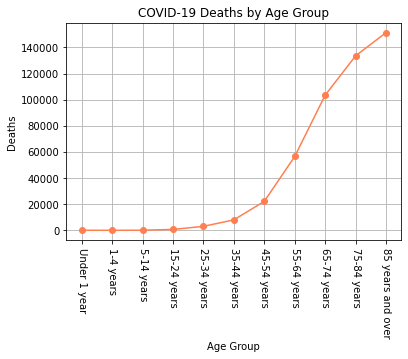

In [11]:
# Continuous line graph of deaths by age group
x = age_df["Age Group"]
y = age_df["COVID-19 Deaths"]

plt.plot(x,y, marker='o', color='coral')
plt.title("COVID-19 Deaths by Age Group")
plt.xlabel("Age Group")
plt.xticks(rotation = 270)
plt.ylabel("Deaths")
plt.grid()

#### Gender

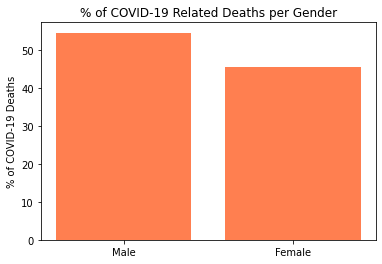

In [12]:
# Plot gender bargraph
plt.bar(['Male', 'Female'], gender_df['% Deaths'] , color = 'coral')
plt.title('% of COVID-19 Related Deaths per Gender')
plt.ylabel('% of COVID-19 Deaths')
plt.show()

#### Comorbidities

Text(0, 0.5, '')

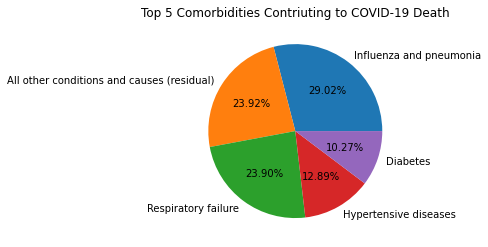

In [13]:
# Getting top 5 contributing comorbidities
sum_lst.remove(sum_lst[-1])
data = {'Condition': conditions, 'Number of Deaths': sum_lst}
df2 = pd.DataFrame(data)
top_5 = df2.nlargest(5, 'Number of Deaths')
top_5.set_index('Condition', inplace=True)

# plotting top 5 comorbidities that contribute to death
plot = top_5.plot.pie(y='Number of Deaths', autopct='%1.2f%%', legend=False, 
                      title='Top 5 Comorbidities Contriuting to COVID-19 Death')
pylab.ylabel('')

#### State

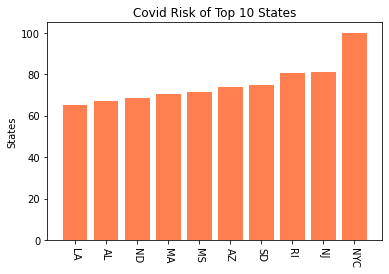

In [14]:
# Creates a bar chart of state/city data
xlabel = 'States'
ylabel = 'Risk Score'
title = 'Covid Risk of Top 10 States'

draw_bar(title, ylabel, xlabel, final_state_scores)

## Randomization

In [15]:
# Dictionary for age range probability
age_dict = {}
for row in age_df.iloc:
    age_dict[row['Age Group']] = row['estimate']

# Dictionary for states probability
total_pop = sum(pop_df['Population'])
pop_percents = {state:
                pop_percent(total_pop, pop_df.iloc[index])
                for index,state in enumerate(pop_df['state'])}


In [16]:
# Generates a shuffled list of states based on actual populations
state_lst = generate_list(pop_percents, COUNT)

# Generates a shuffled list of genders
gender_lst = generate_list({'Male': 0.5, 'Female': 0.5}, COUNT)

# Generates a shuffled list of age ranges
age_lst = generate_list(age_dict, COUNT)

# Generates a shuffled list of occupations
occupation_lst = [random.choice(list(OCCUPATIONS.keys())) for num in range(COUNT)]

# Generates a shuffled list of comorbidities
comor_lst = [random.choice(list(condition_dict.keys())) for num in range(COUNT)]

In [17]:
# Combine randomized sample lists into a dataframe
sample_pop_df = pd.DataFrame({
    'Age': age_lst,
    'Comorbidities': comor_lst,
    'Occupation': occupation_lst,
    'State': state_lst,
    'Gender': gender_lst})

,Age,Comorbidities,Occupation,State,Gender
0,45-54 years,Sepsis,Grocery Store Workers,MO,Female
1,25-34 years,Vascular and unspecified dementia,Food and Agriculture,OH,Male
2,65-74 years,Adult respiratory distress syndrome,Grocery Store Workers,NY,Female
3,5-14 years,Other diseases of the circulatory system,Corrections Workers,TX,Male
4,65-74 years,Alzheimer disease,Food and Agriculture,NY,Female
5,45-54 years,Vascular and unspecified dementia,Public Transit Workers,VA,Male
6,5-14 years,Hypertensive diseases,Public Transit Workers,CO,Female
7,5-14 years,All other conditions and causes (residual),IT and Communication,PA,Female
8,75-84 years,Respiratory arrest,Finance,MS,Male
9,45-54 years,Sepsis,Water and Wastewater,CA,Male


In [18]:
# All final scores for each random sample
final_scores_lst = []

# Calculate final score for each row in dataframe and add to final scores list
for row in sample_pop_df.iloc:
    sample_scores = []
    sample_scores.append(score_age_dict[row['Age']])
    sample_scores.append(condition_dict[row['Comorbidities']])
    sample_scores.append(OCCUPATIONS[row['Occupation']])
    sample_scores.append(final_state_scores[row['State']])
    sample_scores.append(gender_dict[row['Gender']])
    final_scores_lst.append(final_score(sample_scores, WEIGHTS))

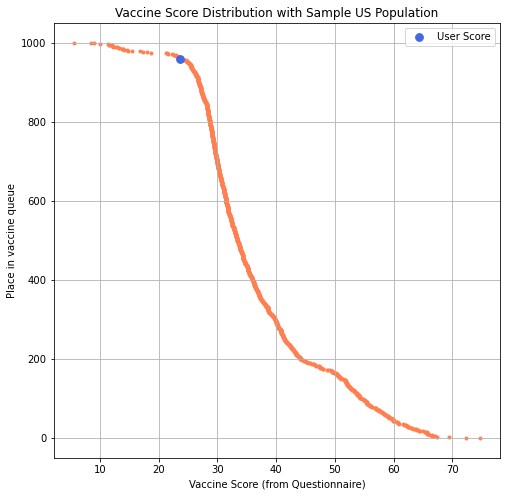

The user inputed score is: 23.6


In [19]:
# Graph the scores in order to see where the user lines up 

# Add user's value
final_scores_lst.append(score_final)
final_scores_lst.sort(reverse = True)

# Order in vaccine queue (Lower value in queue = sooner to get vaccinated)
y = [i for i in range(COUNT+1)]

# color list to mark the user's point
color_lst = ['blue' if num == score_final else 'coral' for num in final_scores_lst]


# Graph
plt.figure(figsize = (8,8))
plt.scatter(final_scores_lst, y,c = 'coral', marker='.')
plt.scatter(score_final, color_lst.index('blue'), c = 'royalblue', marker='o',s = 60, label='User Score')
plt.title("Vaccine Score Distribution with Sample US Population")
plt.xlabel("Vaccine Score (from Questionnaire)")
plt.ylabel("Place in vaccine queue")
plt.legend()
plt.grid()
plt.show()

print('The user inputed score is:', round(score_final, 2))